# **Week 1: EDA and Audio-to-Spectrogram Transformation**

**Goals:**

- Understand the principles of audio-to-spectrogram conversion and its relevance to genre classification.
- Experiment with STFT and Mel spectrogram generation using `librosa`, analyzing the impact of key parameters (window size, hop length, number of Mel bands).
- *Optional:* Briefly explore Constant-Q Transform (CQT).
- For those using pre-extracted 30s features from CSV: Focus on EDA of these features to understand their importance for genre classification. Use visualization and statistical analysis to identify the most discriminative features.
- Document the characteristics of each spectrogram type, parameter effects, and insights from feature analysis to inform future model development.

Table of Contents:

- [Univariate Analysis](##univariate-analysis)
- [Feature Importance](##feature-importance-using-Random-Forest-Classifier)
- [Feature Engineering](##feature-engineering)
- [Dimensionality Reduction](##dimensionality-reduction)

Importing the libraries

In [1]:
# standard imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# for interactivity
import ipywidgets as widgets
from IPython.display import display, clear_output


# sklearn imports
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
# lets read in the data (30s features)

features_30s_df = pd.read_csv('/Users/julienh/Desktop/SDS/SDS-CP018-music-classifier/Data/features_30_sec.csv')

features_30s_df.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,...,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,...,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,...,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,...,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,...,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues


In [3]:
features_30s_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 60 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   filename                 1000 non-null   object 
 1   length                   1000 non-null   int64  
 2   chroma_stft_mean         1000 non-null   float64
 3   chroma_stft_var          1000 non-null   float64
 4   rms_mean                 1000 non-null   float64
 5   rms_var                  1000 non-null   float64
 6   spectral_centroid_mean   1000 non-null   float64
 7   spectral_centroid_var    1000 non-null   float64
 8   spectral_bandwidth_mean  1000 non-null   float64
 9   spectral_bandwidth_var   1000 non-null   float64
 10  rolloff_mean             1000 non-null   float64
 11  rolloff_var              1000 non-null   float64
 12  zero_crossing_rate_mean  1000 non-null   float64
 13  zero_crossing_rate_var   1000 non-null   float64
 14  harmony_mean             

We know that all the features are numerical.

In [4]:

audio_features = features_30s_df.columns[1:-1]
print("audio_features:\n", "\n".join(audio_features.tolist()))


audio_features:
 length
chroma_stft_mean
chroma_stft_var
rms_mean
rms_var
spectral_centroid_mean
spectral_centroid_var
spectral_bandwidth_mean
spectral_bandwidth_var
rolloff_mean
rolloff_var
zero_crossing_rate_mean
zero_crossing_rate_var
harmony_mean
harmony_var
perceptr_mean
perceptr_var
tempo
mfcc1_mean
mfcc1_var
mfcc2_mean
mfcc2_var
mfcc3_mean
mfcc3_var
mfcc4_mean
mfcc4_var
mfcc5_mean
mfcc5_var
mfcc6_mean
mfcc6_var
mfcc7_mean
mfcc7_var
mfcc8_mean
mfcc8_var
mfcc9_mean
mfcc9_var
mfcc10_mean
mfcc10_var
mfcc11_mean
mfcc11_var
mfcc12_mean
mfcc12_var
mfcc13_mean
mfcc13_var
mfcc14_mean
mfcc14_var
mfcc15_mean
mfcc15_var
mfcc16_mean
mfcc16_var
mfcc17_mean
mfcc17_var
mfcc18_mean
mfcc18_var
mfcc19_mean
mfcc19_var
mfcc20_mean
mfcc20_var


In [5]:
def describe_dataframe(df):
    """
    Explores a pandas DataFrame by separating numerical and categorical columns
    and providing descriptive statistics for numerical columns.

    Args:
        df (pd.DataFrame): The input DataFrame.

    Returns:
        tuple: A tuple containing two pandas DataFrames.
            The first DataFrame contains descriptive statistics for numerical columns.
            The second DataFrame contains the names of the non-numerical columns.
    """
    numerical_cols = df.select_dtypes(include=np.number).columns.tolist()
    non_numerical_cols = df.select_dtypes(exclude=np.number).columns.tolist()
    
    print("Non-numerical columns:", non_numerical_cols)
    
    return df[numerical_cols].describe(), non_numerical_cols

numerical_description, non_numerical_columns = describe_dataframe(features_30s_df)
numerical_description

Non-numerical columns: ['filename', 'label']


,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,...,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1.000000e+03,1000.000000,1000.000000,1000.000000,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,662030.846000,0.378682,0.086340,0.130930,0.003051,2201.780898,4.696916e+05,2242.541070,137079.155165,4571.549304,...,1.148144,60.730958,-3.966028,62.633624,0.507696,63.712586,-2.328761,66.231930,-1.095348,70.126096
std,1784.073992,0.081705,0.007735,0.065683,0.003634,715.960600,4.008995e+05,526.316473,96455.666326,1574.791602,...,4.578948,33.781951,4.549697,33.479172,3.869105,34.401977,3.755957,37.174631,3.837007,45.228512
min,660000.000000,0.171939,0.044555,0.005276,0.000004,570.040355,7.911251e+03,898.066208,10787.185064,749.140636,...,-15.693844,9.169314,-17.234728,13.931521,-11.963694,15.420555,-18.501955,13.487622,-19.929634,7.956583
25%,661504.000000,0.319562,0.082298,0.086657,0.000942,1627.697311,1.843505e+05,1907.240605,67376.554428,3380.069642,...,-1.863280,40.376442,-7.207225,40.830875,-2.007015,41.884240,-4.662925,41.710184,-3.368996,42.372865
50%,661794.000000,0.383148,0.086615,0.122443,0.001816,2209.263090,3.384862e+05,2221.392843,111977.548036,4658.524473,...,1.212809,52.325077,-4.065605,54.717674,0.669643,54.804890,-2.393862,57.423059,-1.166289,59.186117
75%,661794.000000,0.435942,0.091256,0.175682,0.003577,2691.294667,6.121479e+05,2578.469836,182371.576801,5533.810460,...,4.359662,71.691755,-0.838737,75.040838,3.119212,75.385832,0.150573,78.626444,1.312615,85.375374
max,675808.000000,0.663685,0.108111,0.397973,0.027679,4435.243901,3.036843e+06,3509.646417,694784.811549,8677.672688,...,13.457150,392.932373,11.482946,406.058868,15.388390,332.905426,14.694924,393.161987,15.369627,506.065155


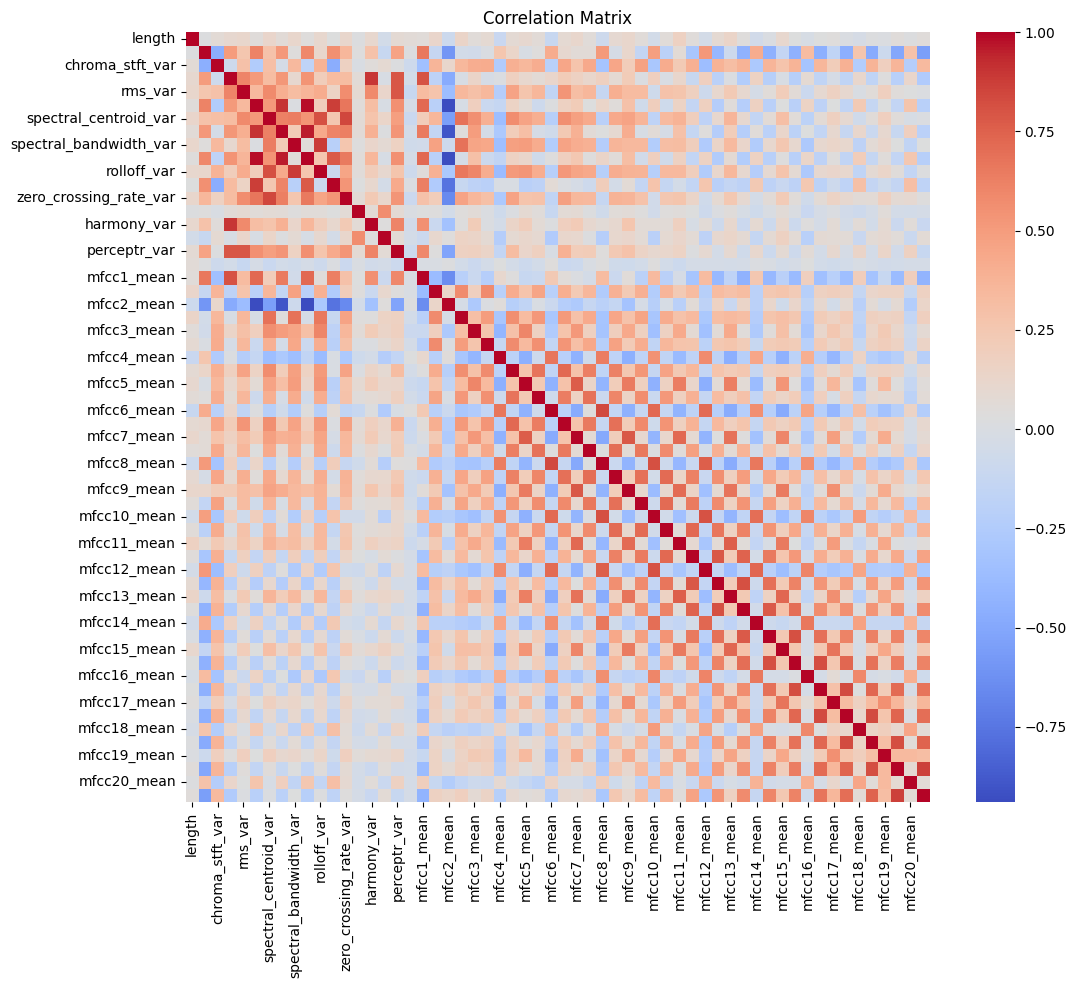

In [6]:
# can explain correlaiton analysis with a correlation matrix (heatmap) 

def plot_correlation_matrix(df, features=None):
    """
    Plots a correlation matrix for the given DataFrame.

    Args:
        df (pd.DataFrame): The input DataFrame.
        features (list, optional): A list of features to include. If None, all numerical features are used.
    """
    if features is None:
        numerical_cols = df.select_dtypes(include=np.number).columns.tolist()
        features = numerical_cols

    corr_matrix = df[features].corr()

    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', fmt=".2f")
    plt.title('Correlation Matrix')
    plt.show()

plot_correlation_matrix(features_30s_df, audio_features.tolist())


**Observations:**

* Red Diagonal Line: The most obvious thing is the strong red diagonal line running from the top left to the bottom right. This is expected in a correlation matrix, showing that each feature is perfectly correlated with itself (correlation of 1).

* Top Left Corner Hotspot: The top left corner is quite "hot" (reddish). This indicates strong positive correlations between features like length, chroma_stft_var, rms_var, spectral_centroid_var, spectral_bandwidth_var, rolloff_var, and zero_crossing_rate_var. It seems these features tend to increase or decrease together in the audio data.

**mfcc Correlations:**

* The mfcc (Mel-Frequency Cepstral Coefficients) features show some interesting patterns. The first few mfcc features (mfcc1_mean to mfcc4_mean) have moderate to strong correlations with the spectral features in the top-left corner. This makes sense, as the lower-order mfccs capture broad spectral shape information.

* There's a checkerboard-like pattern of positive and negative correlations among the mfcc features themselves. For example, neighboring mfccs often have negative correlations (e.g., mfcc2_mean and mfcc3_mean), while those further apart might have positive correlations. This reflects how mfccs are designed to capture different aspects of the spectral envelope.

* mfcc18_mean shows a moderately strong negative correlation with rolloff_var, spectral_centroid_var, and spectral_bandwidth_var, suggesting it may provide a complementary view of the audio's spectral characteristics.

* Harmony and Perceptual Features: harmony_var and perceptr_var don't show strong correlations with many other features, except for a moderate positive correlation between themselves. This suggests they might capture unique aspects of the audio related to harmonic content and perceptual characteristics that are not strongly reflected in the other features.

Because theres a lot of features, I like creating interactive plots with dropdown selectors (possibly selecting more than one feature at a time) to explore the without too many repeated lines of code.

## Univariate Analysis

In [7]:
from utils import plot_feature_interactive

plot_feature_interactive(features_30s_df)

SelectMultiple(description='Features:', options=('length', 'chroma_stft_mean', 'chroma_stft_var', 'rms_mean', …

Dropdown(description='Plot Type:', options=('histogram', 'violinplot', 'boxplot'), value='histogram')

Output()

You can see that most features are normally distributed. Many features have a right skewed distribution. 

In [8]:
from utils import plot_feature_by_label_interactive

# plot the features by label - not normalized
plot_feature_by_label_interactive(features_30s_df)

SelectMultiple(description='Features:', options=('length', 'chroma_stft_mean', 'chroma_stft_var', 'rms_mean', …

Output()

In [15]:
# lets normalize the features
scaler = StandardScaler()
normalized_features = scaler.fit_transform(features_30s_df.drop(columns=['filename', 'label']))
normalized_df = pd.DataFrame(normalized_features, columns=features_30s_df.columns[1:-1])
normalized_df['label'] = features_30s_df['label']

# Plot normalized features
plot_feature_by_label_interactive(normalized_df, label_name='label')

SelectMultiple(description='Features:', options=('length', 'chroma_stft_mean', 'chroma_stft_var', 'rms_mean', …

Output()

## Feature Importance using Random Forest Classifier

We can use a randomforest classifier to classify the genres and look at the feature importance to get a quick understanding of the features that are most important for each genre.

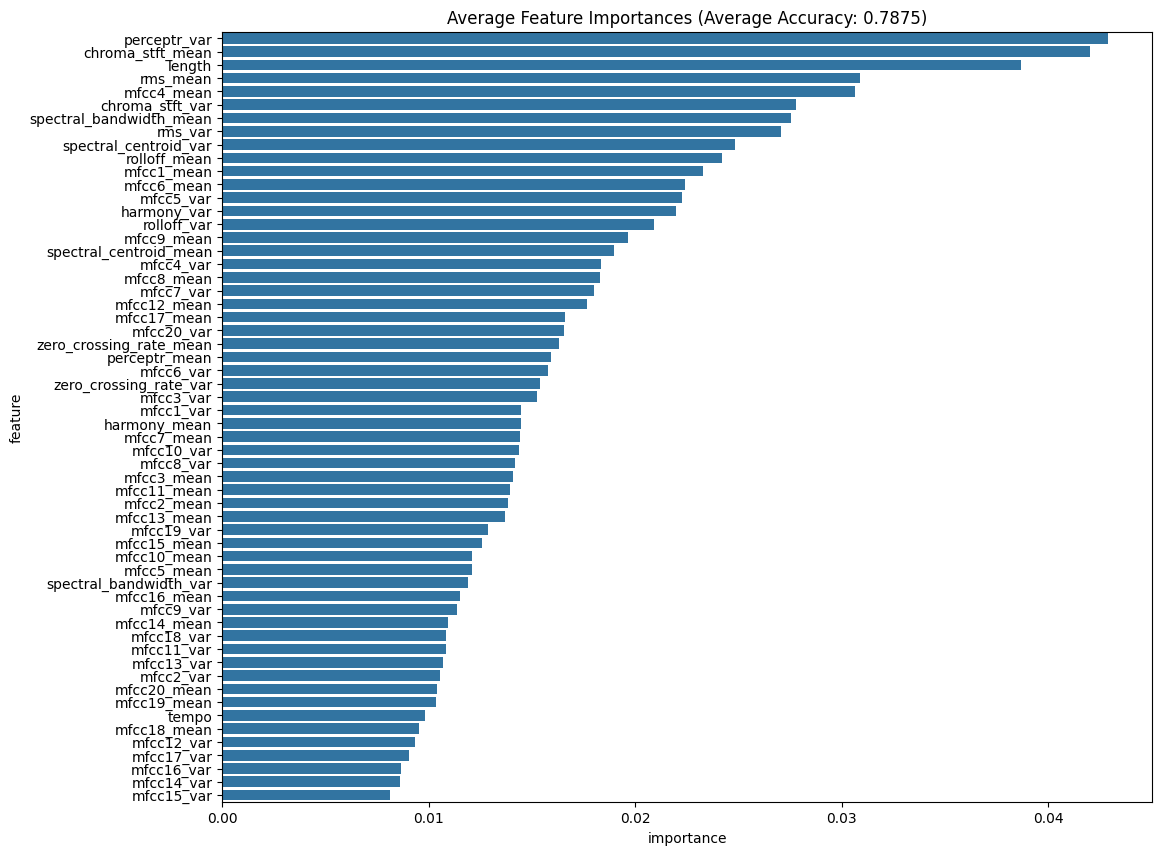

In [16]:
X = features_30s_df.drop(columns=['filename', 'label'])
y = features_30s_df['label']

num_runs = 10  # Number of times to run the RandomForest
feature_importances_list = []
accuracy_list = []

for i in range(num_runs):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42 + i) # add a seed to the random state
    rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_classifier.fit(X_train, y_train)
    feature_importances_list.append(rf_classifier.feature_importances_)
    
    y_pred = rf_classifier.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_list.append(accuracy)

# Average feature importances
average_feature_importances = np.mean(feature_importances_list, axis=0)
average_accuracy = np.mean(accuracy_list)

feature_names = X.columns
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': average_feature_importances})
feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)

plt.figure(figsize=(12, 10))
sns.barplot(x='importance', y='feature', data=feature_importance_df)
plt.title(f'Average Feature Importances (Average Accuracy: {average_accuracy:.4f})')
plt.show()

We can see that the topfeatures are:

- perceptr var
- chroma_stft_mean
- length
-rms)mean
- mfcc4_mean
- chroma_sftf_var

## Feature Engineering

- We could create Ratio/Difference features for each feature, such as `chroma_stft_mean/chroma_stft_var` or `rms_mean/rms_var`.
- Could calculate higher order statistical moments (skewness, kurtosis) for some features, in addition to the mean and variance.

In [54]:
# Calculate skewness and kurtosis for selected features
from scipy.stats import skew, kurtosis


features_30s_expanded_df = features_30s_df.copy(deep=True)

new_features = []

# Create ratio features
ratio_features = ['chroma_stft', 'rms', 'spectral_centroid', 'spectral_bandwidth', 'rolloff', 'zero_crossing_rate', 'harmony', 'perceptr']
for feature in ratio_features:
    new_feature_name = f'{feature}_ratio'
    features_30s_expanded_df[new_feature_name] = features_30s_expanded_df[f'{feature}_mean'] / features_30s_expanded_df[f'{feature}_var']
    new_features.append(new_feature_name)

# Create difference features
diff_features = ['chroma_stft', 'rms', 'spectral_centroid', 'spectral_bandwidth', 'rolloff', 'zero_crossing_rate', 'harmony', 'perceptr']
for feature in diff_features:
    new_feature_name = f'{feature}_diff'
    features_30s_expanded_df[new_feature_name] = features_30s_expanded_df[f'{feature}_mean'] - features_30s_expanded_df[f'{feature}_var']
    new_features.append(new_feature_name)

# Calculate skewness and kurtosis for selected features
skew_kurt_features = ['chroma_stft', 'rms', 'spectral_centroid', 'spectral_bandwidth', 'rolloff', 'zero_crossing_rate', 'harmony', 'perceptr']
for feature in skew_kurt_features:
    new_feature_name = f'{feature}_skew'
    features_30s_expanded_df[new_feature_name] = features_30s_expanded_df[f'{feature}_mean'].skew()
    new_features.append(new_feature_name)
    
    new_feature_name = f'{feature}_kurt'
    features_30s_expanded_df[new_feature_name] = features_30s_expanded_df[f'{feature}_mean'].kurt()
    new_features.append(new_feature_name)

print("List of new features:", new_features)


List of new features: ['chroma_stft_ratio', 'rms_ratio', 'spectral_centroid_ratio', 'spectral_bandwidth_ratio', 'rolloff_ratio', 'zero_crossing_rate_ratio', 'harmony_ratio', 'perceptr_ratio', 'chroma_stft_diff', 'rms_diff', 'spectral_centroid_diff', 'spectral_bandwidth_diff', 'rolloff_diff', 'zero_crossing_rate_diff', 'harmony_diff', 'perceptr_diff', 'chroma_stft_skew', 'chroma_stft_kurt', 'rms_skew', 'rms_kurt', 'spectral_centroid_skew', 'spectral_centroid_kurt', 'spectral_bandwidth_skew', 'spectral_bandwidth_kurt', 'rolloff_skew', 'rolloff_kurt', 'zero_crossing_rate_skew', 'zero_crossing_rate_kurt', 'harmony_skew', 'harmony_kurt', 'perceptr_skew', 'perceptr_kurt']


In [55]:
features_30s_expanded_df[new_features].head()

,chroma_stft_ratio,rms_ratio,spectral_centroid_ratio,spectral_bandwidth_ratio,rolloff_ratio,zero_crossing_rate_ratio,harmony_ratio,perceptr_ratio,chroma_stft_diff,rms_diff,...,spectral_bandwidth_skew,spectral_bandwidth_kurt,rolloff_skew,rolloff_kurt,zero_crossing_rate_skew,zero_crossing_rate_kurt,harmony_skew,harmony_kurt,perceptr_skew,perceptr_kurt
0,3.944363,46.070713,0.013748,0.023316,0.004222,108.279929,-0.005543,0.001366,0.261332,0.127401,...,0.103004,-0.430998,0.116961,-0.454767,0.543045,0.007863,-6.285543,94.304543,-1.481487,7.412528
1,3.589310,40.437572,0.004071,0.009535,0.001192,38.714319,0.027372,-0.057982,0.245933,0.093575,...,0.103004,-0.430998,0.116961,-0.454767,0.543045,0.007863,-6.285543,94.304543,-1.481487,7.412528
2,4.264278,63.938733,0.009924,0.022919,0.003880,75.773743,0.000129,-0.002610,0.278362,0.172824,...,0.103004,-0.430998,0.116961,-0.454767,0.543045,0.007863,-6.285543,94.304543,-1.481487,7.412528
3,4.306264,22.232162,0.005805,0.009591,0.001463,78.789248,0.000024,-0.005340,0.310786,0.134747,...,0.103004,-0.430998,0.116961,-0.454767,0.543045,0.007863,-6.285543,94.304543,-1.481487,7.412528
4,3.512325,39.736391,0.005344,0.019766,0.002276,51.921220,-0.003648,-0.003269,0.220685,0.089225,...,0.103004,-0.430998,0.116961,-0.454767,0.543045,0.007863,-6.285543,94.304543,-1.481487,7.412528


In [9]:
plot_feature_by_label_interactive(features_30s_expanded_df[new_features + ['label']], label_name='label')

NameError: name 'features_30s_expanded_df' is not defined

## Dimensionality Reduction


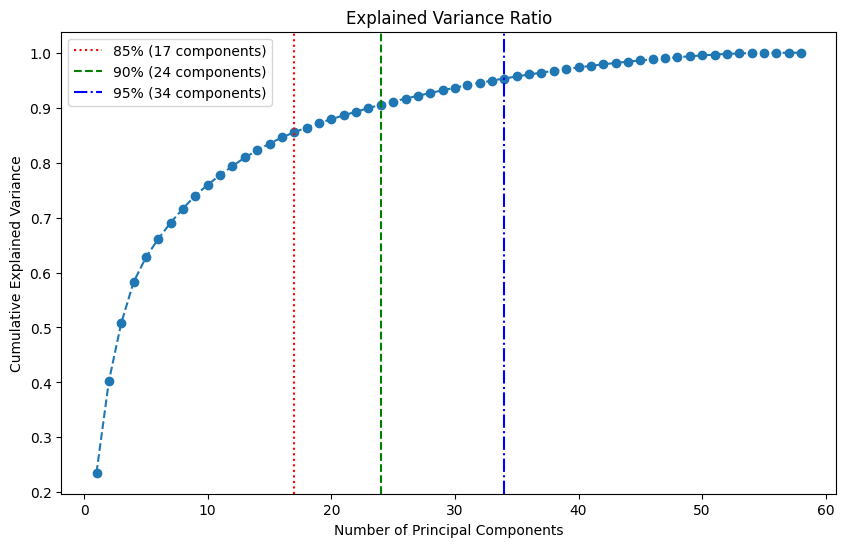

In [26]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Separate features and labels
X = features_30s_df.drop(['filename', 'label'], axis=1)
y = features_30s_df['label']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Plot explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio.cumsum(), marker='o', linestyle='--')
plt.title('Explained Variance Ratio')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')

# Add vertical lines for 85%, 90%, and 95% explained variance
thresholds = [0.85, 0.90, 0.95]
colors = ['red', 'green', 'blue']
linestyles = ['dotted', 'dashed', 'dashdot']

for threshold, color, linestyle in zip(thresholds, colors, linestyles):
    # Find the number of components that explain at least the threshold
    n_components = next(i for i, cumsum in enumerate(explained_variance_ratio.cumsum()) if cumsum >= threshold) + 1
    plt.axvline(x=n_components, color=color, linestyle=linestyle, label=f'{threshold*100:.0f}% ({n_components} components)')

plt.legend()
plt.show()


In [40]:

# choose the number of components that capture a desired amount of variance (e.g., 95%)
n_components_95 = next(i for i, cumsum in enumerate(explained_variance_ratio.cumsum()) if cumsum >= 0.95) + 1
print(f"Number of components that explain at least 95% of the variance: {n_components_95}")

n_components_90 = next(i for i, cumsum in enumerate(explained_variance_ratio.cumsum()) if cumsum >= 0.90) + 1
print(f"Number of components that explain at least 90% of the variance: {n_components_90}")

n_components_85 = next(i for i, cumsum in enumerate(explained_variance_ratio.cumsum()) if cumsum >= 0.85) + 1
print(f"Number of components that explain at least 85% of the variance: {n_components_85}")


# re-apply PCA with the chosen number of components
pca_95 = PCA(n_components=n_components_95)
X_pca_95 = pca_95.fit_transform(X_scaled)

X_pca.shape

Number of components that explain at least 95% of the variance: 34
Number of components that explain at least 90% of the variance: 24
Number of components that explain at least 85% of the variance: 17


(1000, 34)

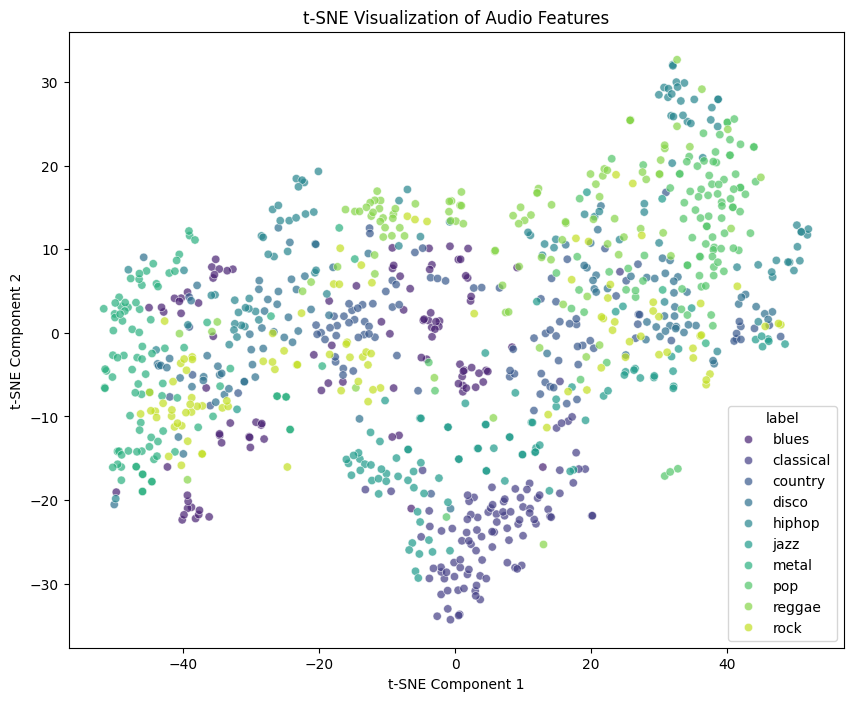

In [21]:

# Apply t-SNE for visualization
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

# Visualize t-SNE results
plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y, palette='viridis', alpha=0.7)
plt.title('t-SNE Visualization of Audio Features')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()


Compared to tsnes (focuses on preserving local structure -- neighborhoods)

Umap preserves both global and local structure

/Users/julienh/.pyenv/versions/3.10.0/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


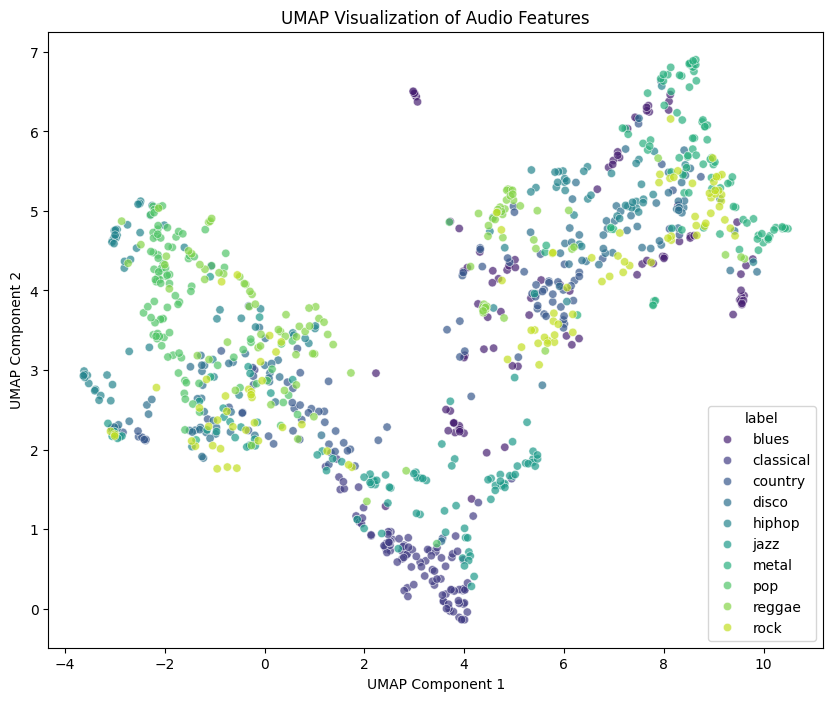

In [25]:
# apply UMAP
from umap import UMAP

umap = UMAP(n_components=2, random_state=42)
X_umap = umap.fit_transform(X_scaled)

plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], hue=y, palette='viridis', alpha=0.7)
plt.title('UMAP Visualization of Audio Features')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.show()


## ML Techniques and Performance

In [50]:
# lets compare X_pca performance (34 components) and normal X (58 features)
# using random forest classifier

# split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply PCA with different explained variance ratios
pca_95 = PCA(n_components=n_components_95)
pca_90 = PCA(n_components=n_components_90)
pca_85 = PCA(n_components=n_components_85)

# Create a dictionary to store the results
results = {
    'PCA: 95% variance': {},
    'PCA: 90% variance': {},
    'PCA: 85% variance': {},
    'Normal (58 features)': {}
}

# Update the function to store the results in the dictionary
def calculate_and_store_accuracies(pca, X_train, X_test, y_train, y_test, label):
    """
    Calculates and stores the accuracies for Random Forest and Gradient Boosting classifiers.

    Parameters:
    pca (PCA object or None): The PCA object used for dimensionality reduction. If None, no PCA is applied.
    X_train (DataFrame): Training data.
    X_test (DataFrame): Testing data.
    y_train (Series): Training labels.
    y_test (Series): Testing labels.
    label (str): The label for storing results in the dictionary.
    """
    if pca:
        X_train_pca = pca.fit_transform(X_train)
        X_test_pca = pca.transform(X_test)
    else:
        X_train_pca = X_train
        X_test_pca = X_test

    # Initialize and train Random Forest Classifier
    rf_classifier = RandomForestClassifier(n_estimators=250, max_depth=6, random_state=42)
    rf_classifier.fit(X_train_pca, y_train)

    # Initialize and train Gradient Boosting Classifier
    gb_classifier = GradientBoostingClassifier(n_estimators=250, max_depth=4, random_state=42)
    gb_classifier.fit(X_train_pca, y_train)

    # Calculate accuracies for Random Forest
    rf_train_accuracy = rf_classifier.score(X_train_pca, y_train)
    rf_test_accuracy = rf_classifier.score(X_test_pca, y_test)

    # Calculate accuracies for Gradient Boosting
    gb_train_accuracy = gb_classifier.score(X_train_pca, y_train)
    gb_test_accuracy = gb_classifier.score(X_test_pca, y_test)

    # Store results in the dictionary
    results[label]['RF Train Accuracy'] = rf_train_accuracy
    results[label]['RF Test Accuracy'] = rf_test_accuracy
    results[label]['GB Train Accuracy'] = gb_train_accuracy
    results[label]['GB Test Accuracy'] = gb_test_accuracy

# Calculate and store accuracies for each PCA and normal data
calculate_and_store_accuracies(pca_95, X_train, X_test, y_train, y_test, 'PCA: 95% variance')
calculate_and_store_accuracies(pca_90, X_train, X_test, y_train, y_test, 'PCA: 90% variance')
calculate_and_store_accuracies(pca_85, X_train, X_test, y_train, y_test, 'PCA: 85% variance')
calculate_and_store_accuracies(None, X_train, X_test, y_train, y_test, 'Normal (58 features)')

# Convert the results dictionary to a DataFrame
results_df = pd.DataFrame(results).T

# Reshape the DataFrame for a multilevel bar plot
results_melted = results_df.reset_index().melt(id_vars='index', var_name='Accuracy Type', value_name='Accuracy')

# Separate the results for Random Forest and Gradient Boosting
rf_results = results_melted[results_melted['Accuracy Type'].str.contains('RF')]
gb_results = results_melted[results_melted['Accuracy Type'].str.contains('GB')]


/var/folders/l5/2h1t38ld23b0fmqx49g_q67c0000gn/T/ipykernel_47733/706419400.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)
/var/folders/l5/2h1t38ld23b0fmqx49g_q67c0000gn/T/ipykernel_47733/706419400.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)


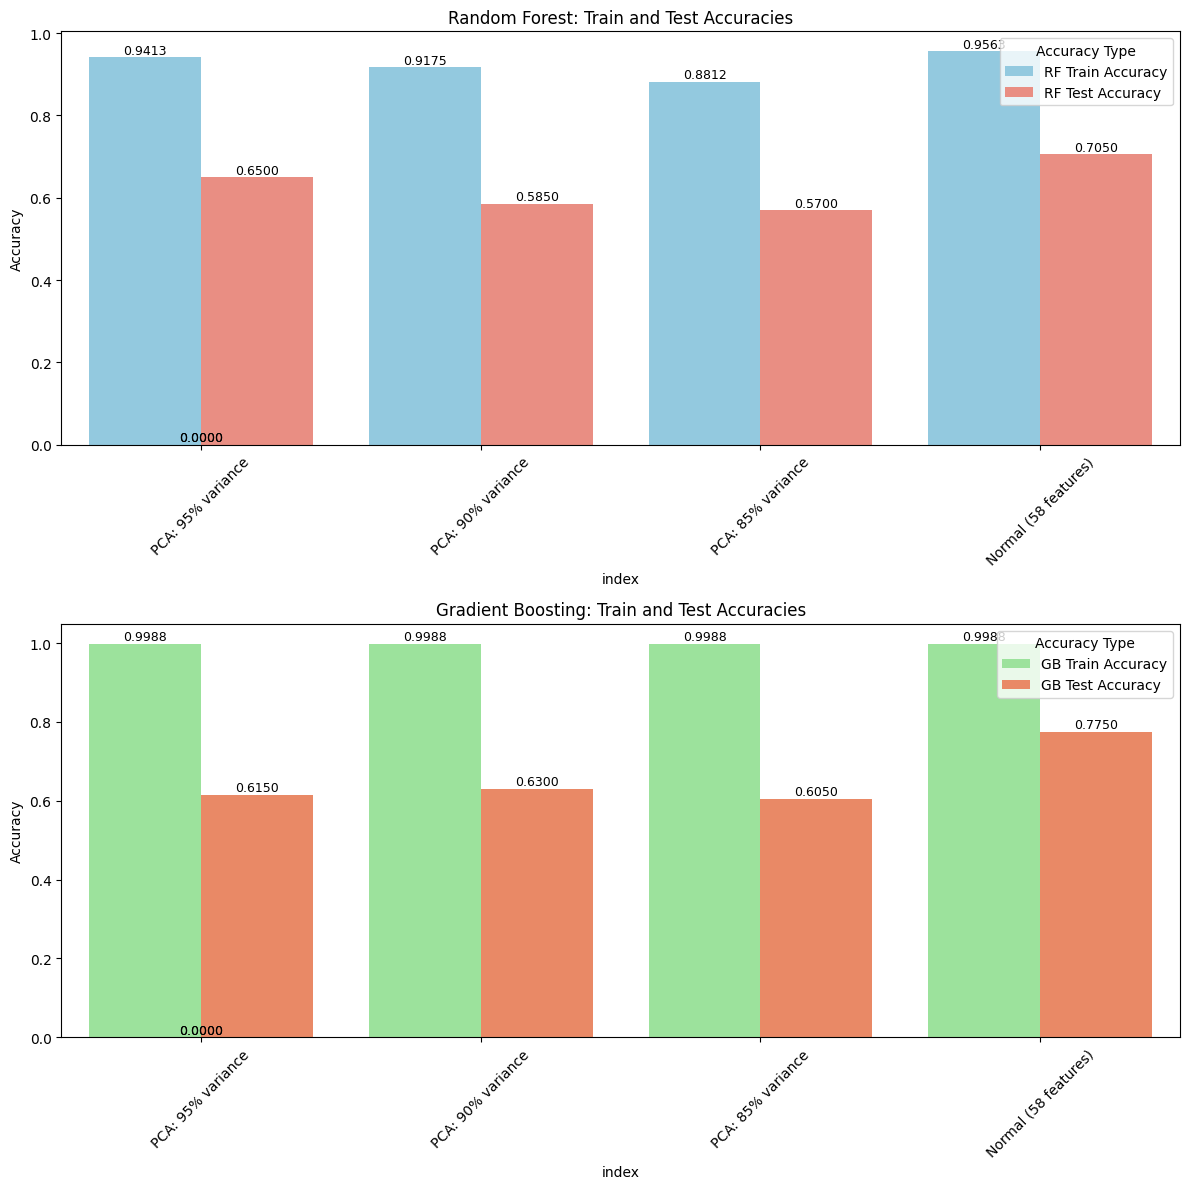

In [51]:

# Plot the results using two separate multilevel bar plots
fig, axes = plt.subplots(2, 1, figsize=(12, 12))

# Random Forest Results
sns.barplot(x='index', y='Accuracy', hue='Accuracy Type', data=rf_results, palette=['skyblue', 'salmon'], ax=axes[0])
axes[0].set_title('Random Forest: Train and Test Accuracies')
axes[0].set_ylabel('Accuracy')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)
axes[0].legend(title='Accuracy Type')

# Add annotations above the bars for Random Forest
for p in axes[0].patches:
    axes[0].annotate(f"{p.get_height():.4f}", (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='center', fontsize=9, color='black', xytext=(0, 5),
                     textcoords='offset points')

# Gradient Boosting Results
sns.barplot(x='index', y='Accuracy', hue='Accuracy Type', data=gb_results, palette=['lightgreen', 'coral'], ax=axes[1])
axes[1].set_title('Gradient Boosting: Train and Test Accuracies')
axes[1].set_ylabel('Accuracy')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)
axes[1].legend(title='Accuracy Type')

# Add annotations above the bars for Gradient Boosting
for p in axes[1].patches:
    axes[1].annotate(f"{p.get_height():.4f}", (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='center', fontsize=9, color='black', xytext=(0, 5),
                     textcoords='offset points')

plt.tight_layout()
plt.show()
